# Машинное обучение, ФКН ВШЭ

## Практическое задание 3. Градиентный спуск своими руками

### Общая информация
Дата выдачи: 05.10.2019

Мягкий дедлайн: 07:59MSK 14.10.2019 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 16.10.2019

### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных вариантов градиентного спуска.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.


### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. 

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 10.0

**Бонус**: 4.01

## Реализация градиентного спуска

Реализуйте линейную регрессию с функцией потерь MSE, обучаемую с помощью:

**Задание 1 (1 балл)** Градиентного спуска;

**Задание 2 (1.5 балла)** Стохастического градиентного спуска;

**Задание 3 (2.5 балла)** Метода Momentum.


Во всех пунктах необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускается использовать только для итераций градиентного спуска;
* В качестве критерия останова необходимо использовать (одновременно):

    * проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$, задаваемого параметром `tolerance`);
    * достижение максимального числа итераций (например, 10000, задаваемого параметром `max_iter`).
* Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса `loss_history` — в нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);
* Инициализировать веса можно случайным образом или нулевым вектором. 


Ниже приведён шаблон класса, который должен содержать код реализации каждого из методов.

In [1]:
import numpy as np
import random
from sklearn.base import BaseEstimator
from sklearn.metrics import r2_score, mean_squared_error

class LinearReg(BaseEstimator):
    def __init__(self, gd_type='stochastic', 
                 tolerance=1e-4, max_iter=1000, w0=None, alpha=1e-3, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic' or 'momentum'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        eta: learning rate
        alpha: momentum coefficient
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.eta = eta
        self.step_size = None
        self.loss_history = None # list of loss function values at each training iteration
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """

        self.loss_history = list()
        if self.w0 == 'random':
            self.w = np.random.rand(X.shape[1])
        else:
            self.w = np.zeros(X.shape[1])
        prev_v = None
        gradient = np.zeros(X.shape[1])
        self.step_size = np.size(y)
        if self.gd_type == 'stochastic':
            self.step_size = 1
        i = 0

        while i < self.max_iter:
            if len(self.loss_history) > 0 and np.linalg.norm(self.w - prev_v) < self.tolerance:
                break
            prev_v = self.w.copy()
            if self.gd_type == 'full':
                gradient = self.calc_gradient(X, y)
                self.w -= self.eta * gradient
            elif self.gd_type == 'stochastic':
                sample = np.random.randint(y.shape[0], size=self.step_size)
                gradient = self.calc_gradient(X[sample], y.take(sample))
                self.w -= self.eta * gradient
            elif self.gd_type == 'momentum':
                prev_grad = gradient.copy()
                gradient = self.calc_gradient(X, y)
                self.w -= self.alpha * prev_grad + self.eta * gradient
            else:
                raise Exception('Choose correct GD type')

            self.loss_history.append(self.calc_loss(X, y))
            i += 1
        return self
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        return X.dot(self.w)
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """

        return 2 * (X.T).dot(self.predict(X) - y) / self.step_size

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """ 

        return np.sum(np.square(self.predict(X) - y)) / np.size(y)

![image](https://sun9-67.userapi.com/c851320/v851320218/1e2b6c/s0vPKWQBMmU.jpg)

**Задание 4 (0 баллов)**. 
* Загрузите данные из домашнего задания 2 ([train.csv](https://www.kaggle.com/c/nyc-taxi-trip-duration/data));
* Разбейте выборку на обучающую и тестовую в отношении 7:3 с random_seed=0;
* Преобразуйте целевую переменную `trip_duration` как $\hat{y} = \log{(y + 1)}$.

In [2]:
import pandas as pd
import warnings
from sklearn.base import TransformerMixin
warnings.filterwarnings('ignore')

data = pd.read_csv("train.csv")

#Преобразования из второго дз
data = data.drop(columns=['dropoff_datetime'])
data.pickup_datetime = pd.to_datetime(data.pickup_datetime)

data['weekday'] = pd.DatetimeIndex(data['pickup_datetime']).weekday
data['month'] = pd.DatetimeIndex(data['pickup_datetime']).month
data['hour'] = pd.DatetimeIndex(data['pickup_datetime']).hour
data['day_num'] = pd.DatetimeIndex(data['pickup_datetime']).dayofyear
data['is_abnormal'] = False
data.loc[(data.day_num == 23), 'is_abnormal'] = True
data.loc[(data.day_num == 24), 'is_abnormal'] = True
data.loc[(data.day_num == 151), 'is_abnormal'] = True

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in d
    ecimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    return 6367 * 2 * np.arcsin(np.sqrt(a))

data['haversine'] = haversine_np(data.pickup_longitude, data.pickup_latitude, data.dropoff_longitude, data.dropoff_latitude)

def safe_ln(x, minval=0.166):
    return np.log(np.clip(x, a_min=minval, a_max=x.max()))

data['log_haversine'] = safe_ln(data.haversine)
data['is_in_traffic_jam'] = False
data.loc[(data.weekday >= 0) & (data.weekday < 6) & (data.hour > 8) & (data.hour < 20),  'is_in_traffic_jam'] = True
data['is_free_roads'] = False
data.loc[(data.hour == 5),  'is_free_roads'] = True
data['La_Guardia_pickup'] = False
data['La_Guardia_dropoff'] = False
data['John_F_Kennedy_pickup'] = False
data['John_F_Kennedy_dropoff'] = False
data.loc[(round(data.pickup_longitude, 2) == -73.87) & (round(data.pickup_latitude, 2) == 40.77),  'La_Guardia_pickup'] = True
data.loc[(round(data.dropoff_longitude, 2) == -73.87) & (round(data.dropoff_latitude, 2) == 40.77),  'La_Guardia_dropoff'] = True
data.loc[(round(data.pickup_longitude, 2) == -73.78) & (round(data.pickup_latitude, 2) == 40.65),  'John_F_Kennedy_pickup'] = True
data.loc[(round(data.dropoff_longitude, 2) == -73.78) & (round(data.dropoff_latitude, 2) == 40.65),  'John_F_Kennedy_dropoff'] = True

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, size_x=7, size_y=5):
        self.size_x = size_x
        self.size_y = size_y
    
    def transform(self, X, y=None):
        df = X.copy()
        lats = np.linspace(40.802505, 40.705128, self.size_x)
        lons = np.linspace(-74.018009, -73.935585, self.size_y)
        
        def _cell(lat, lon):
            cell_num = 0 
            for i in range(self.size_x - 1):
                for j in range(self.size_y - 1):
                    cell_num +=  (j + i * (self.size_y - 1) + 1) * ((lon > lons[j]) & (lat < lats[i]) & (lat > lats[i + 1]) & (lon < lons[j + 1]))
            return cell_num - 1
        
        
        df['pickup_cell'] = _cell(df.pickup_latitude, df.pickup_longitude)
        df['dropoff_cell'] = _cell(df.dropoff_latitude, df.dropoff_longitude)
        df = df.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])
        return df
    
    def fit(self, x, y=None):
        return self

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,day_num,is_abnormal,haversine,log_haversine,is_in_traffic_jam,is_free_roads,La_Guardia_pickup,La_Guardia_dropoff,John_F_Kennedy_pickup,John_F_Kennedy_dropoff
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,...,74,False,1.497580,0.403850,True,False,False,False,False,False
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,...,164,False,1.804374,0.590213,False,False,False,False,False,False
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,...,19,False,6.381090,1.853339,True,False,False,False,False,False
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,...,97,False,1.484566,0.395122,True,False,False,False,False,False
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,...,86,False,1.187842,0.172138,True,False,False,False,False,False


In [3]:
from sklearn.model_selection import train_test_split

y = np.log1p(data["trip_duration"])
X = data.drop(columns=['trip_duration'])

categorical = ['is_abnormal','weekday','month', 'hour', 'day_num',
               'La_Guardia_pickup', 'La_Guardia_dropoff',
               'John_F_Kennedy_pickup', 'John_F_Kennedy_dropoff',
               'is_in_traffic_jam', 'is_free_roads']

numeric = ['haversine', 'log_haversine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

**Задание 5 (3 балла)**. Обучите и провалидируйте модели на данных из предыдущего пункта, сравните качество между методами по метрикам MSE и $R^2$. Исследуйте влияние параметров `max_iter` и `eta` (`max_iter`, `alpha` и `eta` для Momentum) на процесс оптимизации. Согласуется ли оно с вашими ожиданиями?

In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time

max_iters = [500, 1000, 1500]
gd_types = ['full', 'stochastic']
etas = [1e-1, 1e-2, 1e-3]

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)
])

for gd_type in gd_types:
    print('Gd type:', gd_type)
    for max_iter in max_iters:
        print('\t', 'Max iter:', max_iter)
        for eta in etas:
            pipeline = Pipeline(steps=[
                ('MapGridTransformer', MapGridTransformer()),
                ('ohe_and_scaling', column_transformer),
                ('regression', LinearReg(max_iter=max_iter, gd_type=gd_type, eta=eta))
            ])
            start = time.time()
            model = pipeline.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            print('\t\t', 'Time: %.2f' % (time.time() - start))
            print('\t\t', 'Eta:', eta)
            print('\t\t', 'MSE:', mean_squared_error(y_test, y_pred))
            print('\t\t', 'R^2:', r2_score(y_test, y_pred), '\n')

Gd type: full
	 Max iter: 500
		 Time: 89.41
		 Eta: 0.1
		 MSE: 0.23244257858418285
		 R^2: 0.6308374033800825 

		 Time: 58.46
		 Eta: 0.01
		 MSE: 0.25507407209157107
		 R^2: 0.5948943289250364 

		 Time: 60.82
		 Eta: 0.001
		 MSE: 0.3196462157278457
		 R^2: 0.4923416023149749 

	 Max iter: 1000
		 Time: 114.81
		 Eta: 0.1
		 MSE: 0.22919334333282784
		 R^2: 0.6359978009704267 

		 Time: 116.30
		 Eta: 0.01
		 MSE: 0.24789758955996055
		 R^2: 0.6062919349148843 

		 Time: 140.15
		 Eta: 0.001
		 MSE: 0.29196957291089143
		 R^2: 0.5362973241550185 

	 Max iter: 1500
		 Time: 144.88
		 Eta: 0.1
		 MSE: 0.2283423054776599
		 R^2: 0.637349409382058 

		 Time: 127.14
		 Eta: 0.01
		 MSE: 0.24369888790058358
		 R^2: 0.612960263998347 

		 Time: 134.12
		 Eta: 0.001
		 MSE: 0.2800384818628594
		 R^2: 0.5552461440254064 

Gd type: stochastic
	 Max iter: 500
		 Time: 19.45
		 Eta: 0.1
		 MSE: 7388388211242663.0
		 R^2: -1.1734152122695168e+16 

		 Time: 11.10
		 Eta: 0.01
		 MSE: 0.35771744

In [5]:
alphas = [1e-1, 1e-2, 1e-3, 1e-4]

for max_iter in max_iters:
    print('Max iter:', max_iter)
    for alpha in alphas:
        print('\t', 'Alpha:', alpha)
        for eta in etas:
            pipeline = Pipeline(steps=[
                ('MapGridTransformer', MapGridTransformer()),
                ('ohe_and_scaling', column_transformer),
                ('regression', LinearReg(max_iter=max_iter, gd_type='momentum', alpha=alpha, eta=eta))
            ])
            start = time.time()
            model = pipeline.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            print('\t\t', 'Time: %.2f' % (time.time() - start))
            print('\t\t', 'Eta:', eta)
            print('\t\t', 'MSE:', mean_squared_error(y_test, y_pred))
            print('\t\t', 'R^2:', r2_score(y_test, y_pred), '\n')

Max iter: 500
	 Alpha: 0.1
		 Time: 37.41
		 Eta: 0.1
		 MSE: 2.2513626688087045e+66
		 R^2: -3.575587974513737e+66 

		 Time: 37.13
		 Eta: 0.01
		 MSE: 1.189959518934559e+67
		 R^2: -1.889879851437692e+67 

		 Time: 37.63
		 Eta: 0.001
		 MSE: 2.909238073514467e+67
		 R^2: -4.620418031609328e+67 

	 Alpha: 0.01
		 Time: 44.77
		 Eta: 0.1
		 MSE: 0.23182972244204675
		 R^2: 0.6318107343685937 

		 Time: 37.42
		 Eta: 0.01
		 MSE: 0.24790140375928268
		 R^2: 0.6062858772479356 

		 Time: 40.59
		 Eta: 0.001
		 MSE: 0.25397310966905673
		 R^2: 0.5966428646242699 

	 Alpha: 0.001
		 Time: 37.60
		 Eta: 0.1
		 MSE: 0.2323760427663661
		 R^2: 0.63094307479116 

		 Time: 43.95
		 Eta: 0.01
		 MSE: 0.25397003967070314
		 R^2: 0.5966477403599063 

		 Time: 40.54
		 Eta: 0.001
		 MSE: 0.29197692072337195
		 R^2: 0.5362856544447989 

	 Alpha: 0.0001
		 Time: 38.79
		 Eta: 0.1
		 MSE: 0.23243586838575286
		 R^2: 0.6308480604390919 

		 Time: 37.46
		 Eta: 0.01
		 MSE: 0.25495493465923696
		 R^2:

**Задание 6 (2 балла)**. Постройте графики (на одной и той же картинке) зависимости величины функции потерь от номера итерации для полного, стохастического градиентного спусков, а также для полного градиентного спуска с методом Momentum. Сделайте выводы о скорости сходимости различных модификаций градиентного спуска.

Не забывайте о том, что должны получиться *красивые* графики!

**Выводы**: Full и Momentum сходятся лучше, чем Stochastic, при этом Momentum сходится быстрее. Также для Stochastic требуется меньше итераций.

In [6]:
import matplotlib.pyplot as plt

def count_loss(gdtype):
    pipeline = Pipeline(steps=[
        ('MapGridTransformer', MapGridTransformer()),
        ('ohe_and_scaling', column_transformer),
        ('regression', LinearReg(gd_type=gdtype, alpha=1e-2))
    ])
    return pipeline.fit(X_train, y_train)

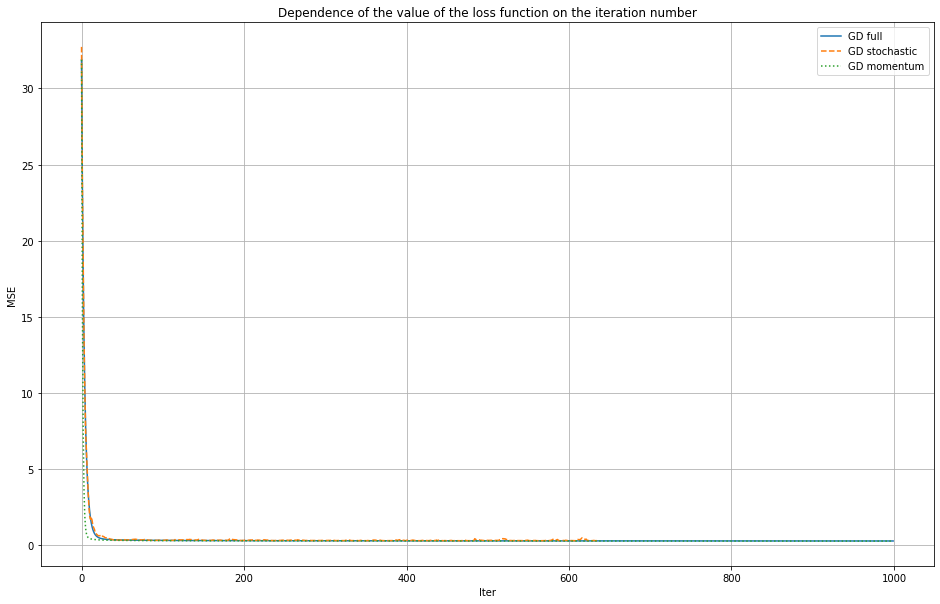

In [7]:
gd_types = ['full', 'stochastic', 'momentum']
linestyles = ['-', '--', ':']
i_ls = 0
plt.figure(figsize=(16, 10))
for gd_type in gd_types:
    model = count_loss(gd_type)
    plt.plot(model.steps[2][1].loss_history, ls=linestyles[i_ls], label=('GD %s' % gd_type))
    i_ls += 1

plt.title('Dependence of the value of the loss function on the iteration number')
plt.xlabel('Iter')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.show()

### Бонус 

**Задание 7 (2 балла)**. Реализуйте линейную регрессию с функцией потерь MSE, обучаемую с помощью метода
[Adam](https://arxiv.org/pdf/1412.6980.pdf) - добавьте при необходимости параметры в класс модели, повторите пункты 5 и 6 и сравните результаты. 

**Выводы**: AdamGD сходится дольше, но лучше остальных.  

In [8]:
class LinearRegWithAdam(LinearReg):
    def __init__(self, gd_type='adam', 
                 tolerance=1e-4, max_iter=1000, w0=None, alpha=1e-3, eta=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        """
        gd_type: 'full' or 'stochastic' or 'momentum'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        eta: learning rate
        alpha: momentum coefficient
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.w = None
        self.eta = eta
        self.step_size = None
        self.loss_history = None # list of loss function values at each training iteration
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """

        self.loss_history = list()
        if self.w0 == 'random':
            self.w = np.random.rand(X.shape[1])
        else:
            self.w = np.zeros(X.shape[1])
        prev_v = None
        gradient = np.zeros(X.shape[1])
        self.step_size = np.size(y)
        if self.gd_type == 'stochastic':
            self.step_size = 1
        m = 0
        v = 0
        i = 1

        while (i <= self.max_iter):
            if len(self.loss_history) > 0 and np.linalg.norm(self.w - prev_v) < self.tolerance:
                break
            prev_v = self.w.copy()
            if self.gd_type == 'full':
                gradient = self.calc_gradient(X, y)
                self.w -= self.eta * gradient
            elif self.gd_type == 'stochastic':
                sample = np.random.randint(y.shape[0], size=self.step_size)
                gradient = self.calc_gradient(X[sample], y.take(sample))
                self.w -= self.eta * gradient
            elif self.gd_type == 'momentum':
                prev_grad = gradient.copy()
                gradient = self.calc_gradient(X, y)
                self.w -= self.alpha * prev_grad + self.eta * gradient
            elif self.gd_type == 'adam':
                gradient = self.calc_gradient(X, y)
                m = self.beta_1 * m + (1 - self.beta_1) * gradient
                v = self.beta_2 * v + (1 - self.beta_2) * np.square(gradient)
                m_t = m / (1 - np.power(self.beta_1, i))
                v_t = v / (1 - np.power(self.beta_2, i))
                self.w -= self.eta * m_t / (np.sqrt(v_t) + self.epsilon)
            else:
                raise Exception('Choose correct GD type')

            self.loss_history.append(self.calc_loss(X, y))
            i += 1
        return self

Когда прочитал статью и самостоятельно реализовал градиентный спуск с помощью Adam:
![image](https://i.kym-cdn.com/entries/icons/mobile/000/025/351/afoeeee.jpg)

In [9]:
epsilons = [1e-6, 1e-8, 1e-10]

for epsilon in epsilons:
    print('Epsilon:', epsilon)
    for max_iter in max_iters:
        print('\t', 'Max iter:', max_iter)
        for eta in etas:
            pipeline = Pipeline(steps=[
                ('MapGridTransformer', MapGridTransformer()),
                ('ohe_and_scaling', column_transformer),
                ('regression', LinearRegWithAdam(gd_type='adam', max_iter=max_iter, eta=eta, epsilon=epsilon))
            ])
            start = time.time()
            model = pipeline.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            print('\t\t', 'Time: %.2f' % (time.time() - start))
            print('\t\t', 'Eta:', eta)
            print('\t\t', 'MSE:', mean_squared_error(y_test, y_pred))
            print('\t\t', 'R^2:', r2_score(y_test, y_pred), '\n')

Epsilon: 1e-06
	 Max iter: 500
		 Time: 49.18
		 Eta: 0.1
		 MSE: 0.22769529557565146
		 R^2: 0.6383769829742935 

		 Time: 63.91
		 Eta: 0.01
		 MSE: 0.2277334024394963
		 R^2: 0.6383164620968721 

		 Time: 64.21
		 Eta: 0.001
		 MSE: 4.971607811444281
		 R^2: -6.8958496340374245 

	 Max iter: 1000
		 Time: 48.69
		 Eta: 0.1
		 MSE: 0.22769529557565146
		 R^2: 0.6383769829742935 

		 Time: 94.73
		 Eta: 0.01
		 MSE: 0.22770948552850934
		 R^2: 0.6383544466564002 

		 Time: 121.85
		 Eta: 0.001
		 MSE: 0.4052135069554201
		 R^2: 0.35644462677929933 

	 Max iter: 1500
		 Time: 49.19
		 Eta: 0.1
		 MSE: 0.22769529557565146
		 R^2: 0.6383769829742935 

		 Time: 90.71
		 Eta: 0.01
		 MSE: 0.22770948552850934
		 R^2: 0.6383544466564002 

		 Time: 179.28
		 Eta: 0.001
		 MSE: 0.24000755132697119
		 R^2: 0.6188228017606326 

Epsilon: 1e-08
	 Max iter: 500
		 Time: 49.90
		 Eta: 0.1
		 MSE: 0.2276952955947975
		 R^2: 0.6383769829438859 

		 Time: 63.34
		 Eta: 0.01
		 MSE: 0.22773339781656546


In [10]:
def count_loss(gdtype):
    pipeline = Pipeline(steps=[
        ('MapGridTransformer', MapGridTransformer()),
        ('ohe_and_scaling', column_transformer),
        ('regression', LinearRegWithAdam(gd_type=gdtype, alpha=1e-2, epsilon=1e-10))
    ])
    return pipeline.fit(X_train, y_train)

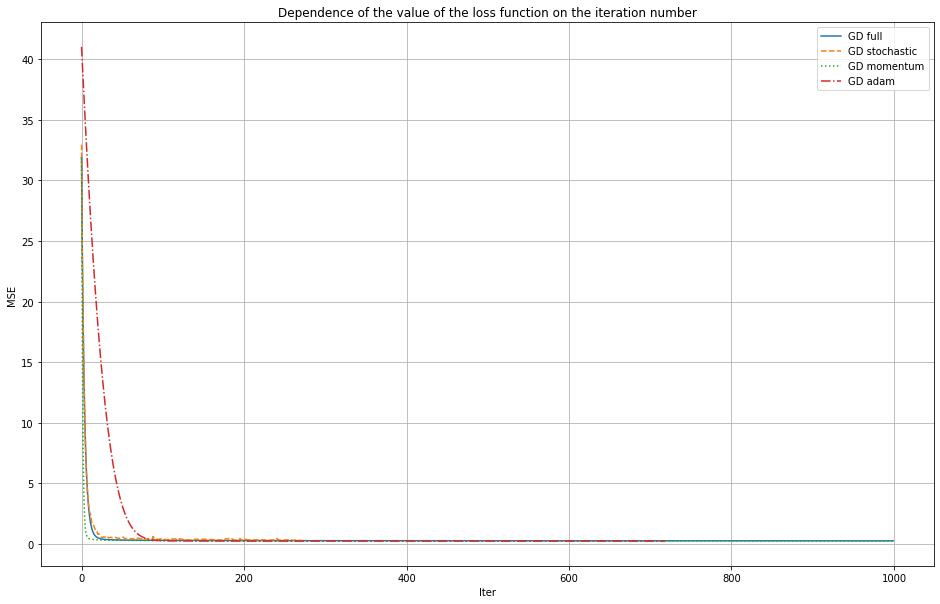

In [11]:
gd_types = ['full', 'stochastic', 'momentum', 'adam']
linestyles = ['-', '--', ':', '-.']
i_ls = 0
plt.figure(figsize=(16, 10))
for gd_type in gd_types:
    model = count_loss(gd_type)
    plt.plot(model.steps[2][1].loss_history, ls=linestyles[i_ls], label=('GD %s' % gd_type))
    i_ls += 1

plt.title('Dependence of the value of the loss function on the iteration number')
plt.xlabel('Iter')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.show()

**Задание 8 (2 балла)**. Реализуйте линейную регрессию с функцией потерь
$$ L(\hat{y}, y) = log(cosh(\hat{y} - y)),$$

обучаемую с помощью градиентного спуска.

In [12]:
class LinearRegLogCosh(LinearRegWithAdam):
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """

        return (X.T).dot(np.tanh(self.predict(X) - y)) / self.step_size

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """ 
        return (np.log(np.cosh(self.predict(X) - y))).sum() / np.size(y)

LogCosh Error: 0.1031374268697087
MSE: 0.2635353263906819


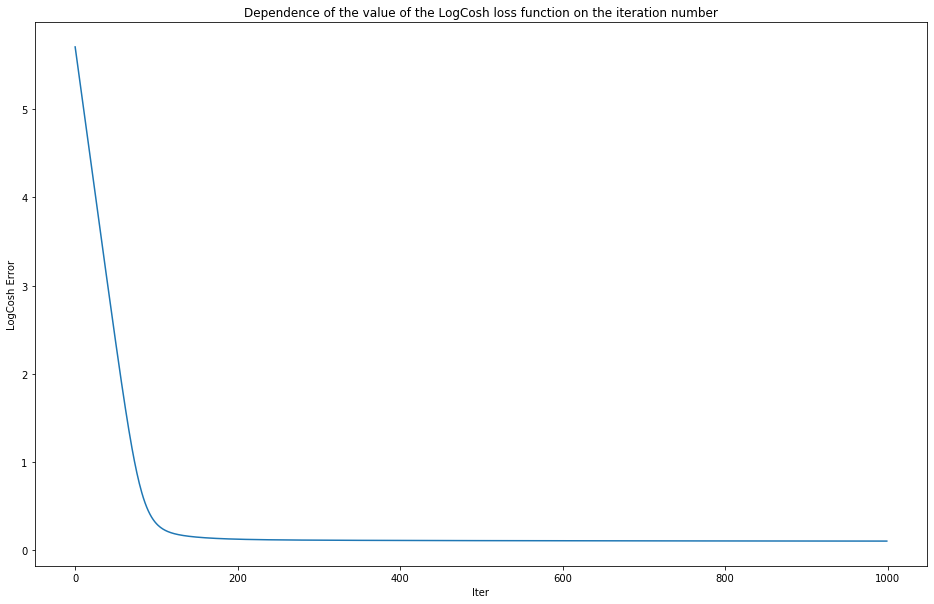

In [14]:
pipeline = Pipeline(steps=[
    ('MapGridTransformer', MapGridTransformer()),
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearRegLogCosh(gd_type='full'))
])
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('LogCosh Error:', np.log(np.cosh(y_test - y_pred)).sum() / y_test.size)
print('MSE:', mean_squared_error(y_test, y_pred))

plt.figure(figsize=(16, 10))
plt.plot(model.steps[2][1].loss_history)
plt.title('Dependence of the value of the LogCosh loss function on the iteration number')
plt.xlabel('Iter')
plt.ylabel('LogCosh Error')
plt.show()

**Задание 9 (0.01 балла)**.  Вставьте картинку с вашим любимым мемом в этот Jupyter Notebook

![image](https://sun9-25.userapi.com/c848628/v848628835/1b06e3/N9qHLsRYzUY.jpg)